# ⚡ Training Workflow (1–14)
이 구간은 빠르게 데이터 일부로 end-to-end 학습과 검증을 수행하는 스모크 테스트 플로우입니다. 아래 순서대로 각 셀을 실행하세요.

# 1. Import required libraries


In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
import sys, math, json, random, contextlib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torch_geometric.datasets import AirfRANS
from torch_geometric.data import Data, Batch
from matplotlib.tri import Triangulation
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch_geometric.data import Data
from navier_stokes_physics_loss import NavierStokesPhysicsLoss
from airfrans_utils import prepare_airfrans_graph_for_physics, estimate_node_area, build_bc_masks_airfrans
import contextlib
import wandb  
from torch.cuda.amp import GradScaler, autocast

def get_lr(optim):
    return optim.param_groups[0].get('lr', None)


def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
set_seed(42)
print('SmokeTest | PyTorch:', torch.__version__, '| CUDA?', torch.cuda.is_available())

SmokeTest | PyTorch: 2.8.0+cu128 | CUDA? True


# 2. Set Configuration

In [2]:
# 2) Configuration (minimal for smoke)
from dataclasses import dataclass, asdict

@dataclass
class SmokeCfg:
    seed: int = 42
    task: str = 'scarce'
    root: str = 'Dataset'
    # subsample graph count for smoke
    limit_train: int = 180
    limit_val: int = 20

    # training
    batch_size: int = 1
    epochs: int = 100
    hidden: int = 128
    layers: int = 7
    lr: float = 4e-4
    weight_decay: float = 1e-2  # typical AdamW wd
    betas: tuple[float, float] = (0.9, 0.95)
    eps: float = 1e-8
    amp: bool = False

    # lr scheduler: 'cosine', 'cosine_warm_restarts', 'reduce_on_plateau', or None
    lr_scheduler: str = 'cosine'
    # cosine params
    cosine_T_max: int = 80  # epochs
    cosine_eta_min: float = 1e-6
    # warm restarts params
    wr_T_0: int = 10
    wr_T_mult: int = 1
    wr_eta_min: float = 1e-6
    # reduce on plateau params
    rop_factor: float = 0.5
    rop_patience: int = 5
    rop_min_lr: float = 1e-6

    # Physics-Informed Loss Configuration
    # =====================================
    # Curriculum learning schedule
    ramp_start_epoch: int = 30              # Epoch to start ramping physics losses
    ramp_epochs: int = 80                   # Number of epochs to ramp up
    ramp_mode: str = 'linear'               # 'linear' or 'cosine'
    
    # MSE/Data loss
    data_loss_weight: float = 1.0           # Weight for MSE loss (constant)
    
    # Continuity equation loss
    continuity_loss_weight: float = 0.05    # Initial continuity weight
    continuity_target_weight: float = 0.10  # Target continuity weight after ramp
    
    # Momentum equation loss  
    momentum_loss_weight: float = 0.05      # Initial momentum weight
    momentum_target_weight: float = 0.10    # Target momentum weight after ramp
    
    # Boundary condition loss
    bc_loss_weight: float = 0.05            # Weight for boundary condition loss
    
    # Physics parameters
    chord_length: float = 1.0               # Airfoil chord length
    nu_molecular: float = 1.5e-5            # Molecular viscosity
    dynamic_uref_from_data: bool = True     # Compute reference velocity from data
    dynamic_re_from_data: bool = True       # Compute Reynolds number from data
    uinf_from: str = 'inlet'                # 'inlet', 'farfield', or 'robust'
    
    # Stability & outlier control
    use_huber_for_physics: bool = True      # Use Huber loss for physics terms
    huber_delta: float = 0.05               # Huber loss delta parameter
    use_perimeter_norm_for_div: bool = True # Normalize divergence by perimeter
    div_area_floor_factor: float = 0.25     # Area floor factor for stability
    div_min_degree: int = 2                 # Minimum node degree for physics loss
    
    # Debug & monitoring
    physics_debug: bool = False              # Enable physics loss debugging
    physics_debug_level: int = 1            # Debug verbosity (1=summary, 2=detailed)
    physics_debug_every: int = 50           # Log debug info every N steps

    # Global Context & Attention Configuration
    use_global_tokens: bool = True           # Enable/disable global tokens
    num_global_tokens: int = 4               # Number of global tokens
    attention_heads: int = 4                 # Multi-head attention heads
    attention_layers: int = 7               # Number of transformer layers
    attention_dropout: float = 0.0           # Attention dropout rate
    use_cross_attention: bool = True         # Cross-attention between local and global
    global_pooling_type: str = 'attention'   # 'mean', 'max', 'attention', 'set2set'
    positional_encoding: bool = True         # Use positional encoding
    pos_encoding_max_len: int = 50000        # Max sequence length for positional encoding
    # Advanced attention options
    use_residual_attention: bool = True      # Residual connections in attention
    attention_normalization: str = 'layer'   # 'layer', 'batch', 'rms'
    temperature_scaling: bool = True         # Temperature scaling for attention
    attention_bias: bool = False             # Use bias in attention projections

    # W&B Artifact 관리
    use_wandb_artifacts: bool = False        # W&B artifact 사용 여부
    artifact_save_best_only: bool = True     # best 모델만 업로드
    artifact_save_interval: int = 50         # periodic 저장 간격 (epochs)
    
    # Checkpoint 관리
    ckpt_dir: str = "checkpoints"           # 로컬 체크포인트 디렉토리
    ckpt_interval: int = 5                  # 로컬 체크포인트 저장 간격
    
    # W&B 설정
    wandb_project: str = "airfrans-gnn"
    wandb_mode: str = "online"              # "online", "offline", "disabled"
    log_every_n_steps: int = -1             # 로깅 빈도
    log_epoch_only: bool = True             # Epoch 로깅만 사용

scfg = SmokeCfg()
set_seed(scfg.seed)
print('Smoke config:', asdict(scfg))

Smoke config: {'seed': 42, 'task': 'scarce', 'root': 'Dataset', 'limit_train': 180, 'limit_val': 20, 'batch_size': 1, 'epochs': 100, 'hidden': 128, 'layers': 7, 'lr': 0.0004, 'weight_decay': 0.01, 'betas': (0.9, 0.95), 'eps': 1e-08, 'amp': False, 'lr_scheduler': 'cosine', 'cosine_T_max': 80, 'cosine_eta_min': 1e-06, 'wr_T_0': 10, 'wr_T_mult': 1, 'wr_eta_min': 1e-06, 'rop_factor': 0.5, 'rop_patience': 5, 'rop_min_lr': 1e-06, 'ramp_start_epoch': 30, 'ramp_epochs': 80, 'ramp_mode': 'linear', 'data_loss_weight': 1.0, 'continuity_loss_weight': 0.05, 'continuity_target_weight': 0.1, 'momentum_loss_weight': 0.05, 'momentum_target_weight': 0.1, 'bc_loss_weight': 0.05, 'chord_length': 1.0, 'nu_molecular': 1.5e-05, 'dynamic_uref_from_data': True, 'dynamic_re_from_data': True, 'uinf_from': 'inlet', 'use_huber_for_physics': True, 'huber_delta': 0.05, 'use_perimeter_norm_for_div': True, 'div_area_floor_factor': 0.25, 'div_min_degree': 2, 'physics_debug': False, 'physics_debug_level': 1, 'physics_de

# 3. Load dataset indices

In [3]:
from torch_geometric.transforms import BaseTransform

class _PreparePhysics(BaseTransform):
    def __call__(self, data):
        # edge_attr_dxdy가 이미 있을 경우 build_edge_attr_dxdy는 생략되고 나머지만 수행
        return prepare_airfrans_graph_for_physics(data, verbose=False)

# 3) Load dataset indices (train/val split)
assert os.path.isdir(scfg.root), f"Dataset folder not found: {scfg.root}"
try:
    ds_train = AirfRANS(root=scfg.root, train=True, task=scfg.task, transform=_PreparePhysics())
    ds_test  = AirfRANS(root=scfg.root, train=False, task=scfg.task, transform=_PreparePhysics())
except TypeError:
    ds_train = AirfRANS(root=scfg.root, train=True, transform=_PreparePhysics())
    ds_test  = AirfRANS(root=scfg.root, train=False, transform=_PreparePhysics())

if scfg.task == 'scarce':
    # Scarce provides train only; create 90/10 split from ds_train
    n = len(ds_train)
    ids_all = list(range(n))
    random.Random(scfg.seed).shuffle(ids_all)
    ids_train = ids_all[:n]
    # limit if requested
    if scfg.limit_train > 0:
        ids_train = ids_train[:scfg.limit_train + scfg.limit_val]
        
    train_raw = Subset(ds_train, ids_train)
    val_raw = None
    
else:
    ids_train = list(range(min(scfg.limit_train+scfg.limit_val, len(ds_train))))
    ids_val = ids_train[-scfg.limit_val:] if scfg.limit_val>0 else []
    ids_train = ids_train[:scfg.limit_train] if scfg.limit_train>0 else ids_train
    train_raw = Subset(ds_train, ids_train)
    val_raw   = Subset(ds_train, ids_val) if ids_val else []

print('Loaded subset indices:', len(train_raw), 'train |', len(val_raw) if isinstance(val_raw, Subset) else 0, 'val/test')

Loaded subset indices: 200 train | 0 val/test


# 4. Load prebuilt graphs and ensure features (index-aligned with raw)

In [4]:
# 6) Load prebuilt graphs and ensure features (index-aligned with raw)
import glob, os, re
from utils import with_pos2, prep_graph, validate_edges, _prep_graph_for_norm

USE_PREBUILT = True
PREBUILT_ROOT = 'prebuilt_edges/scarce'  # change to your path if different
PREBUILT_TRAIN_DIR = f"{PREBUILT_ROOT}/train"
PREBUILT_TEST_DIR  = f"{PREBUILT_ROOT}/test"
DOWNSAMPLED_ROOT = 'downsampled_graphs/scarce'

# Load prebuilt edge graphs
train_edge_files = sorted(glob.glob(os.path.join(PREBUILT_TRAIN_DIR, 'graph_*.pt')))
val_edge_files   = sorted(glob.glob(os.path.join(PREBUILT_TEST_DIR,  'graph_*.pt')))
print(f"[prebuilt] found: {len(train_edge_files)} train and {len(val_edge_files)} val graphs under {PREBUILT_ROOT}")

# Load tensors and prepare
train_edges = []
for p in train_edge_files:
    d = torch.load(p, map_location='cpu', weights_only=False)
    if not isinstance(d, Data):
        d = Data(**d)
    train_edges.append(prep_graph(d))

val_edges = []
for p in val_edge_files:
    d = torch.load(p, map_location='cpu', weights_only=False)
    if not isinstance(d, Data):
        d = Data(**d)
    val_edges.append(prep_graph(d))

print(f"Graphs prepared. Example dims -> x: {train_edges[0].x.shape if len(train_edges)>0 else None}  edge_attr: {train_edges[0].edge_attr.shape if (len(train_edges)>0 and hasattr(train_edges[0],'edge_attr') and train_edges[0].edge_attr is not None) else None}")

validate_edges(train_edges, 'train_edges')

[prebuilt] found: 200 train and 0 val graphs under prebuilt_edges/scarce
Graphs prepared. Example dims -> x: torch.Size([16124, 5])  edge_attr: torch.Size([95510, 5])
[validate] train_edges: total=200 bad=0
Graphs prepared. Example dims -> x: torch.Size([16124, 5])  edge_attr: torch.Size([95510, 5])
[validate] train_edges: total=200 bad=0


# 5. Normalized datasets


In [5]:
if scfg.task == 'scarce':
    n = len(train_edges)
    n_train = int(n * 0.9)
    ids_all = list(range(n))
    random.Random(scfg.seed).shuffle(ids_all)
    ids_train = ids_all[:n_train]
    ids_val = ids_all[n_train:]

    # Use prebuilt graphs, not raw dataset
    train_edges_subset = [train_edges[i] for i in ids_train]
    val_edges_subset = [train_edges[i] for i in ids_val] if ids_val else []
else:
    train_edges_subset = train_edges
    val_edges_subset = val_edges

train_prepped = [_prep_graph_for_norm(g) for g in train_edges_subset]
val_prepped   = [_prep_graph_for_norm(g) for g in val_edges_subset] if isinstance(val_edges_subset, list) else []

# 8b) Fit scalers on train_prepped
if 'StandardScaler' not in globals():
    class StandardScaler:
        def __init__(self):
            self.mean = None
            self.std = None
        def fit(self, t: torch.Tensor):
            self.mean = t.mean(dim=0)
            self.std = t.std(dim=0).clamp_min(1e-8)
            return self
        def transform(self, t: torch.Tensor):
            return (t - self.mean) / self.std
        def inverse(self, t: torch.Tensor):
            return t * self.std + self.mean

# Concatenate node features/targets across train graphs for fitting
X_train = torch.cat([d.x for d in train_prepped if hasattr(d, 'x') and d.x is not None], dim=0)
Y_train = torch.cat([d.y for d in train_prepped if hasattr(d, 'y') and d.y is not None], dim=0)

x_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(Y_train)

# 8c) Build normalized dataset wrappers
class NormalizedDataset(torch.utils.data.Dataset):
    def __init__(self, graphs, x_scaler, y_scaler):
        self.graphs = graphs
        self.x_scaler = x_scaler
        self.y_scaler = y_scaler
        
    def __len__(self):
        return len(self.graphs)
        
    def __getitem__(self, idx: int):
        d = self.graphs[idx]
        dm = Data(**{k: v for k, v in d})
        dm.x = self.x_scaler.transform(d.x)
        if hasattr(d, 'y') and d.y is not None:
            dm.y = self.y_scaler.transform(d.y)
        else:
            dm.y = d.y
            
        # Ensure edge_attr_dxdy exists and has exactly 2 dimensions for physics loss
        if hasattr(dm, 'edge_attr_dxdy') and dm.edge_attr_dxdy is not None:
            # If edge_attr_dxdy exists but has wrong shape, fix it
            if dm.edge_attr_dxdy.shape[-1] != 2:
                dm.edge_attr_dxdy = dm.edge_attr_dxdy[:, :2]  # Take only first 2 dims
        elif hasattr(dm, 'edge_attr') and dm.edge_attr is not None:
            # Create edge_attr_dxdy from edge_attr (first 2 dimensions)
            dm.edge_attr_dxdy = dm.edge_attr[:, :2]
        else:
            # Create dummy edge_attr_dxdy if nothing exists
            num_edges = dm.edge_index.shape[1]
            dm.edge_attr_dxdy = torch.ones(num_edges, 2) * 0.01
            
        # Attach norm params for downstream
        dm.x_norm_params = {'mean': self.x_scaler.mean.clone(), 'scale': self.x_scaler.std.clone()}
        dm.y_norm_params = {'mean': self.y_scaler.mean.clone(), 'scale': self.y_scaler.std.clone()} if dm.y is not None else None
        return dm
        
        
train_norm = NormalizedDataset(train_prepped, x_scaler, y_scaler)
val_norm   = NormalizedDataset(val_prepped, x_scaler, y_scaler) if isinstance(val_prepped, list) and len(val_prepped) > 0 else []

# Debug data structure
sample = train_norm[0]
print("\n🔍 Debugging data structure:")
print(f"  x shape: {sample.x.shape}")
print(f"  y shape: {sample.y.shape}")
print(f"  edge_index shape: {sample.edge_index.shape}")

if hasattr(sample, 'edge_attr'):
    print(f"  edge_attr shape: {sample.edge_attr.shape}")
    print(f"  edge_attr sample: {sample.edge_attr[0]}")
    
if hasattr(sample, 'edge_attr_dxdy'):
    print(f"  edge_attr_dxdy shape: {sample.edge_attr_dxdy.shape}")
    print(f"  edge_attr_dxdy sample: {sample.edge_attr_dxdy[0]}")
else:
    print("  ⚠️ edge_attr_dxdy not found")
    
    # Create edge_attr_dxdy from edge_attr if possible
    if hasattr(sample, 'edge_attr') and sample.edge_attr is not None:
        # Use first 2 dimensions of edge_attr as dx, dy
        sample.edge_attr_dxdy = sample.edge_attr[:, :2]
        print(f"  ✅ Created edge_attr_dxdy from edge_attr[:, :2]")

print('Prepared normalized datasets:', len(train_norm), 'train |', (len(val_norm) if isinstance(val_norm, NormalizedDataset) else len(val_norm)), 'val')
if len(train_prepped) > 0:
    print('Example dims -> x:', tuple(train_prepped[0].x.shape), '| edge_attr:', (tuple(train_prepped[0].edge_attr.shape) if hasattr(train_prepped[0], 'edge_attr') and train_prepped[0].edge_attr is not None else None))



🔍 Debugging data structure:
  x shape: torch.Size([16059, 7])
  y shape: torch.Size([16059, 4])
  edge_index shape: torch.Size([2, 94686])
  edge_attr shape: torch.Size([94686, 5])
  edge_attr sample: tensor([ 0.0034,  0.6972, -0.7169,  0.0000,  0.0000])
  edge_attr_dxdy shape: torch.Size([94686, 2])
  edge_attr_dxdy sample: tensor([ 0.0024, -0.0025])
Prepared normalized datasets: 180 train | 20 val
Example dims -> x: (16059, 7) | edge_attr: (94686, 5)


In [6]:
data = train_norm[0]

row, col = data.edge_index
deg = torch.bincount(row, minlength=data.num_nodes) + torch.bincount(col, minlength=data.num_nodes)
print("deg==0:", int((deg==0).sum()), " / ", data.num_nodes)
print("deg<2 :", int((deg<2).sum()))


deg==0: 88  /  16059
deg<2 : 88


# 6. DataLoaders


In [7]:
# Use true batching with PyG Batch.from_data_list so batch_size>1 works correctly

def collate_pyg(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None
    return Batch.from_data_list(batch)

train_loader = DataLoader(train_norm, batch_size=scfg.batch_size, shuffle=True, num_workers=0, collate_fn=collate_pyg)
val_loader   = DataLoader(val_norm,   batch_size=scfg.batch_size, shuffle=False, num_workers=0, collate_fn=collate_pyg) if isinstance(val_norm, NormalizedDataset) else []
print('Loaders ready:', len(train_norm), 'train samples | batch_size =', scfg.batch_size)
print('Loaders ready:', len(val_norm), 'val samples | batch_size =', scfg.batch_size)

Loaders ready: 180 train samples | batch_size = 1
Loaders ready: 20 val samples | batch_size = 1


# 7. Train/Val epoch routines

In [8]:
# 13) Enhanced Train/Val epoch routines with Physics Loss
def compute_loss_with_physics(predictions, targets, data, loss_fn=None, *, step: int | None = None):
    """Compute loss using physics-informed loss function or fallback to MSE
    Returns a differentiable scalar loss tensor for backward as first value,
    and a lightweight dict of float metrics for logging as second value.
    """
    if loss_fn is not None:
        try:
            # Always let the physics loss handle batched Data (PyG batches are a big disjoint graph)
            loss_dict = loss_fn(predictions, targets, data=data, step=step)

            # Ensure total_loss is a Tensor usable for backward
            total_loss = loss_dict.get('total_loss')
            if not isinstance(total_loss, torch.Tensor):
                total_loss = torch.as_tensor(total_loss, dtype=predictions.dtype, device=predictions.device)

            # Prepare a logging-friendly dict (floats only) to avoid holding graph refs
            log_dict = {}
            for k, v in loss_dict.items():
                if isinstance(v, torch.Tensor):
                    try:
                        log_dict[k] = float(v.detach().item())
                    except Exception:
                        # Fallback if it's not 0-dim
                        log_dict[k] = float(v.detach().mean().item())
                else:
                    log_dict[k] = float(v)

            return total_loss, log_dict
        except Exception as e:
            print(f"Warning: Physics loss failed ({e}), falling back to MSE")
            mse_loss = mse_loss_fn(predictions, targets)
            return mse_loss, {
                'mse_loss': float(mse_loss.detach().item()), 
                'continuity_loss': 0.0, 
                'momentum_loss': 0.0,
                'bc_loss': 0.0,  # ← BC loss 추가
                'total_loss': float(mse_loss.detach().item())
            }
    else:
        # Fallback to simple MSE
        mse_loss = mse_loss_fn(predictions, targets)
        return mse_loss, {
            'mse_loss': float(mse_loss.detach().item()), 
            'bc_loss': 0.0,  # ← BC loss 추가
            'total_loss': float(mse_loss.detach().item())
        }


@torch.no_grad()
def run_epoch(loader, model, device, scaler=None, desc: str = 'val', loss_fn=None):
    model.eval()
    total_losses = []; mse_losses = []; continuity_losses = []; momentum_losses = []
    bc_losses = []  # ← BC loss 리스트 추가
    cont_w_used_hist, mom_w_used_hist = [], []

    if loader is None or (isinstance(loader, list) and len(loader)==0):
        return float('nan'), {}

    steps = len(loader)
    pbar = tqdm(total=steps, desc=desc, leave=False)

    for batch in loader:
        try:
            if batch is None:
                pbar.update(1); continue

            b = batch.to(device)
            with (autocast(enabled=(scfg.amp and torch.cuda.is_available()))
                  if torch.cuda.is_available() else contextlib.nullcontext()):
                out = model(b)
                _, loss_dict = compute_loss_with_physics(out, b.y, b, loss_fn=loss_fn, step=None)

            total_losses.append(loss_dict['total_loss'])
            mse_losses.append(loss_dict['mse_loss'])
            continuity_losses.append(loss_dict.get('continuity_loss', 0.0))
            momentum_losses.append(loss_dict.get('momentum_loss', 0.0))
            bc_losses.append(loss_dict.get('bc_loss', 0.0))  # ← BC loss 수집
            if 'cont_weight_used' in loss_dict: cont_w_used_hist.append(loss_dict['cont_weight_used'])
            if 'mom_weight_used'  in loss_dict: mom_w_used_hist.append(loss_dict['mom_weight_used'])

            postfix = {"total": f"{loss_dict['total_loss']:.4e}"}
            if 'continuity_loss' in loss_dict: postfix["cont"] = f"{loss_dict['continuity_loss']:.4e}"
            if 'momentum_loss' in loss_dict:   postfix["momentum"] = f"{loss_dict['momentum_loss']:.4e}"
            if 'bc_loss' in loss_dict:         postfix["bc"] = f"{loss_dict['bc_loss']:.4e}"  # ← BC loss 표시
            pbar.set_postfix(postfix)

        finally:
            pbar.update(1)

    pbar.close()

    avg_losses = {
        'total_loss': np.mean(total_losses) if total_losses else float('nan'),
        'mse_loss': np.mean(mse_losses) if mse_losses else float('nan'),
        'continuity_loss': np.mean(continuity_losses) if continuity_losses else float('nan'),
        'momentum_loss': np.mean(momentum_losses) if momentum_losses else float('nan'),
        'bc_loss': np.mean(bc_losses) if bc_losses else float('nan'),  # ← BC loss 평균
    }
    if cont_w_used_hist: avg_losses['cont_weight_used'] = float(np.mean(cont_w_used_hist))
    if mom_w_used_hist:  avg_losses['mom_weight_used']  = float(np.mean(mom_w_used_hist))
    return avg_losses['total_loss'], avg_losses



def train_epoch_enhanced(loader, model, optim, device, scaler, desc='train',
                         loss_fn=None, global_step_start=0):
    model.train()
    losses_tracker = {
        'total': [], 
        'mse': [], 
        'continuity': [], 
        'momentum': [],
        'bc': [],  # Add BC tracking
        'turbulence_production': [], 
        'turbulence_dissipation': [],
        'smoothness': [], 
        'wall_function': []
    }
    total_losses, mse_losses, continuity_losses, momentum_losses = [], [], [], []
    bc_losses = []
    cont_w_used_hist, mom_w_used_hist = [], []

    global_step = global_step_start
    steps = len(loader)
    pbar = tqdm(total=steps, desc=desc, leave=False)

    for batch_idx, batch in enumerate(loader):
        try:
            if batch is None:
                pbar.update(1); global_step += 1; continue

            b = batch.to(device)
            optim.zero_grad(set_to_none=True)

            use_scaler = (scaler is not None) and getattr(scaler, "is_enabled", lambda: False)()

            if use_scaler:
                with autocast(enabled=torch.cuda.is_available()):
                    out = model(b)
                    loss, loss_dict = compute_loss_with_physics(out, b.y, b, loss_fn=loss_fn, step=global_step)
                scaler.scale(loss).backward()
                scaler.unscale_(optim)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optim)
                scaler.update()
            else:
                with contextlib.nullcontext():
                    out = model(b)
                    loss, loss_dict = compute_loss_with_physics(out, b.y, b, loss_fn=loss_fn, step=global_step)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optim.step()

            if scheduler is not None and scheduler_step_mode == "step":
                try:
                    scheduler.step()
                except TypeError:
                    pass

            # 집계
            total_losses.append(loss_dict['total_loss'])
            mse_losses.append(loss_dict['mse_loss'])
            continuity_losses.append(loss_dict.get('continuity_loss', 0.0))
            momentum_losses.append(loss_dict.get('momentum_loss', 0.0))
            bc_losses.append(loss_dict.get('bc_loss', 0.0))
            if 'cont_weight_used' in loss_dict: cont_w_used_hist.append(loss_dict['cont_weight_used'])
            if 'mom_weight_used'  in loss_dict: mom_w_used_hist.append(loss_dict['mom_weight_used'])

            # === Step-level 로깅 완전 제거 또는 조건부 비활성화 ===
            if log_every_n_steps > 0 and (batch_idx % max(1, log_every_n_steps)) == 0:
                # Step-level 로깅을 원하는 경우에만 실행
                log_payload = {
                    "step": global_step,
                    "train/total": loss_dict['total_loss'],
                    "train/mse": loss_dict['mse_loss'],
                    "train/continuity": loss_dict.get('continuity_loss', 0.0),
                    "train/momentum": loss_dict.get('momentum_loss', 0.0),
                    "train/bc": loss_dict.get('bc_loss', 0.0),
                }
                if 'cont_weight_used' in loss_dict: log_payload["weight/cont_used"] = loss_dict['cont_weight_used']
                if 'mom_weight_used'  in loss_dict: log_payload["weight/mom_used"]  = loss_dict['mom_weight_used']
                lr_now = get_lr(optim)
                if lr_now is not None:
                    log_payload["lr"] = lr_now
                wandb.log(log_payload, step=global_step, commit=False)

            postfix = {"total": f"{loss_dict['total_loss']:.4e}",
                       "lr": f"{get_lr(optim):.2e}" if get_lr(optim) is not None else "n/a"}
            if 'continuity_loss' in loss_dict: postfix["cont"] = f"{loss_dict['continuity_loss']:.4e}"
            if 'momentum_loss' in loss_dict:   postfix["momentum"] = f"{loss_dict['momentum_loss']:.4e}"
            if 'bc_loss' in loss_dict:         postfix["bc"] = f"{loss_dict['bc_loss']:.4e}"
            pbar.set_postfix(postfix)

        finally:
            pbar.update(1)
            global_step += 1

    pbar.close()

    avg_losses = {}
    for key in losses_tracker:
        loss_key = f'{key}_loss' if key != 'total' else 'total_loss'
        values = losses_tracker[key]
        avg_losses[loss_key] = np.mean(values) if values else 0.0
    
    return avg_losses['total_loss'], avg_losses, global_step

In [ ]:
# Force reload the physics loss module to ensure we have latest version
import importlib
import sys

# Remove from cache if it exists
if 'physics_loss_with_turbulent_modeling' in sys.modules:
    del sys.modules['physics_loss_with_turbulent_modeling']

# Fresh import
from turbulent_modeling_physics_loss import EnhancedPhysicsLoss

# Verify the methods exist
print("✅ Checking EnhancedPhysicsLoss methods:")
required_methods = ['_compute_divergence_loss', '_compute_momentum_loss', 
                   '_compute_turbulence_losses', '_compute_bc_loss', 
                   '_compute_smoothness_loss', '_compute_wall_function_loss']

for method in required_methods:
    if hasattr(EnhancedPhysicsLoss, method):
        print(f"   ✓ {method}")
    else:
        print(f"   ✗ {method} MISSING!")

print("Module reloaded successfully")

✅ Checking EnhancedPhysicsLoss methods:
   ✗ _compute_divergence_loss MISSING!
   ✗ _compute_momentum_loss MISSING!
   ✗ _compute_turbulence_losses MISSING!
   ✗ _compute_bc_loss MISSING!
   ✗ _compute_smoothness_loss MISSING!
   ✗ _compute_wall_function_loss MISSING!
Module reloaded successfully


In [10]:
# Recreate the loss function with the properly loaded class
print("\n🔄 Recreating enhanced physics loss...")

# Steps per epoch calculation for curriculum learning
steps_per_epoch = len(train_loader)

# Initialize enhanced physics loss with curriculum learning
loss_fn = EnhancedPhysicsLoss(
    # Basic weights with curriculum learning
    data_loss_weight=scfg.data_loss_weight,
    continuity_loss_weight=scfg.continuity_loss_weight,
    continuity_target_weight=scfg.continuity_target_weight,
    momentum_loss_weight=scfg.momentum_loss_weight, 
    momentum_target_weight=scfg.momentum_target_weight,
    bc_loss_weight=scfg.bc_loss_weight,
    
    # New turbulence terms
    turbulence_loss_weight=0.05,
    rans_loss_weight=0.05,
    smoothness_weight=0.01,
    wall_function_weight=0.02,
    
    # Curriculum learning parameters
    curriculum_ramp_steps=scfg.ramp_epochs * steps_per_epoch,
    ramp_start_step=scfg.ramp_start_epoch * steps_per_epoch,
    ramp_mode=scfg.ramp_mode,
    
    # Physical parameters
    nu_molecular=scfg.nu_molecular,
    chord_length=scfg.chord_length,
    
    # Control
    use_adaptive_weights=False,
    debug=scfg.physics_debug,
)

print(f"✅ Enhanced Physics Loss recreated successfully!")
print(f"   Curriculum: start at epoch {scfg.ramp_start_epoch}, ramp for {scfg.ramp_epochs} epochs")
print(f"   Continuity: {scfg.continuity_loss_weight:.3f} → {scfg.continuity_target_weight:.3f}")
print(f"   Momentum: {scfg.momentum_loss_weight:.3f} → {scfg.momentum_target_weight:.3f}")
print(f"   BC weight: {scfg.bc_loss_weight:.3f} (constant)")

# Test the loss function on a sample
print("\n🧪 Testing physics loss on sample data...")
test_batch = next(iter(train_loader)).to(device)

with torch.no_grad():
    try:
        test_output = enhanced_model(test_batch)
        test_output = torch.clamp(test_output, -10, 10)  # Clamp for safety
        
        # Test physics loss
        loss_dict = loss_fn(test_output, test_batch.y, data=test_batch, step=0)
        
        print("✅ Physics loss components:")
        for key, value in loss_dict.items():
            if isinstance(value, torch.Tensor):
                val = value.detach().item()
                print(f"   {key}: {val:.4e}")
        
    except Exception as e:
        print(f"❌ Physics loss test failed: {e}")
        import traceback
        traceback.print_exc()


🔄 Recreating enhanced physics loss...
✅ Enhanced Physics Loss recreated successfully!
   Curriculum: start at epoch 30, ramp for 80 epochs
   Continuity: 0.050 → 0.100
   Momentum: 0.050 → 0.100
   BC weight: 0.050 (constant)

🧪 Testing physics loss on sample data...
❌ Physics loss test failed: name 'enhanced_model' is not defined


Traceback (most recent call last):
  File "C:\Users\Kim\AppData\Local\Temp\ipykernel_5552\1300746843.py", line 49, in <module>
    test_output = enhanced_model(test_batch)
                  ^^^^^^^^^^^^^^
NameError: name 'enhanced_model' is not defined


# 8. Model & Loss


In [ ]:
from turbulent_modeling_physics_loss import EnhancedPhysicsLoss
from global_context_processor import UltraEnhancedCFDModel

# Steps per epoch 계산 (curriculum learning용)
steps_per_epoch = len(train_loader)

# Initialize enhanced physics loss with curriculum learning
loss_fn = EnhancedPhysicsLoss(
    # Basic weights with curriculum learning
    data_loss_weight=scfg.data_loss_weight,
    continuity_loss_weight=scfg.continuity_loss_weight,
    continuity_target_weight=scfg.continuity_target_weight,  # Now supported!
    momentum_loss_weight=scfg.momentum_loss_weight, 
    momentum_target_weight=scfg.momentum_target_weight,      # Now supported!
    bc_loss_weight=scfg.bc_loss_weight,
    
    # New turbulence terms
    turbulence_loss_weight=0.05,
    rans_loss_weight=0.05,
    smoothness_weight=0.01,
    wall_function_weight=0.02,
    
    # Curriculum learning parameters
    curriculum_ramp_steps=scfg.ramp_epochs * steps_per_epoch,
    ramp_start_step=scfg.ramp_start_epoch * steps_per_epoch,
    ramp_mode=scfg.ramp_mode,
    
    # Physical parameters
    nu_molecular=scfg.nu_molecular,
    chord_length=scfg.chord_length,
    
    # Control
    use_adaptive_weights=False,
    debug=scfg.physics_debug,
)


print(f"✅ Enhanced Physics Loss initialized with curriculum learning:")
print(f"   Curriculum: start at epoch {scfg.ramp_start_epoch}, ramp for {scfg.ramp_epochs} epochs")
print(f"   Continuity: {scfg.continuity_loss_weight:.3f} → {scfg.continuity_target_weight:.3f}")
print(f"   Momentum: {scfg.momentum_loss_weight:.3f} → {scfg.momentum_target_weight:.3f}")
print(f"   BC weight: {scfg.bc_loss_weight:.3f} (constant)")
print(f"   Turbulence: {0.05:.3f}, RANS: {0.05:.3f}")
print(f"   Smoothness: {0.01:.3f}, Wall function: {0.02:.3f}")

# Initialize enhanced model
enhanced_model = UltraEnhancedCFDModel(
    node_feat_dim=7,
    edge_feat_dim=5,
    hidden_dim=scfg.hidden,
    output_dim=4,
    num_mp_layers=scfg.layers,
    num_scales=3,  # Multi-scale levels
    dropout_p=0.1,
    config=scfg
).to(device)

# Enhanced optimizer with different learning rates for different components
optimizer_groups = [
    {'params': enhanced_model.base_model.parameters(), 'lr': scfg.lr},
    {'params': enhanced_model.multi_scale_convs.parameters(), 'lr': scfg.lr * 0.5},
    {'params': enhanced_model.output_head.parameters(), 'lr': scfg.lr * 1.5},
]
enhanced_optimizer = torch.optim.AdamW(
    optimizer_groups,
    weight_decay=scfg.weight_decay,
    betas=scfg.betas,
    eps=scfg.eps
)


# Initialize model weights more carefully
def init_weights(m):
    if isinstance(m, (nn.Linear, nn.Conv1d)):
        nn.init.xavier_uniform_(m.weight, gain=0.5)  # Smaller gain
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)
    elif isinstance(m, (nn.LayerNorm, nn.BatchNorm1d)):
        nn.init.constant_(m.weight, 1.0)
        nn.init.constant_(m.bias, 0.0)

enhanced_model.apply(init_weights)
print("✅ Model weights initialized with Xavier uniform (gain=0.5)")

# Also reduce the initial learning rate
for param_group in enhanced_optimizer.param_groups:
    param_group['lr'] = param_group['lr'] * 0.1  # Start with 10% of configured LR

print(f"✅ Initial learning rate reduced to {enhanced_optimizer.param_groups[0]['lr']:.2e}")


[OK] Enhanced Global Context & Attention Mechanism loaded!
Features: Multi-head attention, cross-attention, positional encoding, advanced pooling
✅ Enhanced Physics Loss initialized with curriculum learning:
   Curriculum: start at epoch 30, ramp for 80 epochs
   Continuity: 0.050 → 0.100
   Momentum: 0.050 → 0.100
   BC weight: 0.050 (constant)
   Turbulence: 0.050, RANS: 0.050
   Smoothness: 0.010, Wall function: 0.020
✅ Model weights initialized with Xavier uniform (gain=0.5)
✅ Initial learning rate reduced to 4.00e-05


# 9. Set-up learning rate schedule

In [12]:
# Learning Rate Scheduler 설정
def create_lr_scheduler(optimizer, config):
    """Configuration에 따라 적절한 LR scheduler를 생성합니다."""
    
    if config.lr_scheduler is None:
        print("🚫 Learning rate scheduler: None (constant LR)")
        return None
    
    elif config.lr_scheduler == 'cosine':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=config.cosine_T_max,
            eta_min=config.cosine_eta_min
        )
        print(f"📊 Learning rate scheduler: CosineAnnealingLR")
        print(f"   T_max: {config.cosine_T_max}, eta_min: {config.cosine_eta_min}")
        return scheduler
    
    elif config.lr_scheduler == 'cosine_warm_restarts':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer,
            T_0=config.wr_T_0,
            T_mult=config.wr_T_mult,
            eta_min=config.wr_eta_min
        )
        print(f"🔄 Learning rate scheduler: CosineAnnealingWarmRestarts")
        print(f"   T_0: {config.wr_T_0}, T_mult: {config.wr_T_mult}, eta_min: {config.wr_eta_min}")
        return scheduler
    
    elif config.lr_scheduler == 'reduce_on_plateau':
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',  # validation loss를 minimize
            factor=config.rop_factor,
            patience=config.rop_patience,
            min_lr=config.rop_min_lr,
        )
        print(f"📉 Learning rate scheduler: ReduceLROnPlateau")
        print(f"   factor: {config.rop_factor}, patience: {config.rop_patience}, min_lr: {config.rop_min_lr}")
        return scheduler
    
    else:
        print(f"❌ Unknown scheduler: {config.lr_scheduler}, using None")
        return None

# Enhanced optimizer를 생성한 후에 scheduler 생성
enhanced_scheduler = create_lr_scheduler(enhanced_optimizer, scfg)

print(f"\n🎯 Current configuration:")
print(f"   Initial LR: {scfg.lr}")
print(f"   Scheduler: {scfg.lr_scheduler}")
print(f"   Epochs: {scfg.epochs}")

📊 Learning rate scheduler: CosineAnnealingLR
   T_max: 80, eta_min: 1e-06

🎯 Current configuration:
   Initial LR: 0.0004
   Scheduler: cosine
   Epochs: 100


# wandb set-up

In [13]:
# === Weights & Biases init ===
# scfg에 project/name/tags가 없더라도 안전하게 동작하도록 기본값 준비
wandb_init_kwargs = dict(
    project=getattr(scfg, "wandb_project", "airfrans-gnn"),
    name=getattr(scfg, "wandb_run_name", None),           # ex) f"exp_{time.time():.0f}"
    tags=getattr(scfg, "wandb_tags", None),               # ex) ["physics", "navier-stokes"]
    mode=getattr(scfg, "wandb_mode", "online"),           # "online"|"offline"|"disabled"
    settings=wandb.Settings(start_method="thread"),
    config={
        # 기본 하이퍼 파라미터를 config로 기록
        "epochs": getattr(scfg, "epochs", None),
        "batch_size": getattr(scfg, "batch_size", None),
        "lr": getattr(scfg, "lr", None),
        "optimizer": getattr(scfg, "optimizer", "adam"),
        "scheduler": getattr(scfg, "scheduler", None),
        "amp": getattr(scfg, "amp", False),
        # physics loss 주요 값
        "cont_w0": getattr(loss_fn, "cont_w0", None),
        "cont_w_target": getattr(loss_fn, "cont_w_target", None),
        "mom_w0": getattr(loss_fn, "mom_w0", None),
        "mom_w_target": getattr(loss_fn, "mom_w_target", None),
        "ramp_steps": getattr(loss_fn, "curr_steps", None),
        "ramp_start_step": getattr(loss_fn, "ramp_start_step", 0),
    }
)
wandb_run = wandb.init(**wandb_init_kwargs)

# Make wandb log per-epoch only: swallow per-step logs (commit=False)
try:
    _wandb_orig_log = wandb.log
    def _log_epoch_only(data=None, step=None, commit=None, *args, **kwargs):
        # Preserve default behavior: commit defaults to True when not provided
        if commit is None:
            commit = True
        # Ignore any step-level logs that explicitly use commit=False
        if commit is False:
            return
        return _wandb_orig_log(data, step=step, commit=commit, *args, **kwargs)
    wandb.log = _log_epoch_only
except Exception:
    pass

# Disable gradient/parameter histogram logging (step-based)
try:
    # Previously: wandb.watch(model, log="gradients", log_freq=100)
    # Avoid step-wise logging entirely
    pass  # skip watch
except Exception:
    pass


wandb: WARNING `start_method` is deprecated and will be removed in a future version of wandb. This setting is currently non-functional and safely ignored.
wandb: Currently logged in as: jyk-snuai (jyk-snuai-seoul-national-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: jyk-snuai (jyk-snuai-seoul-national-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [14]:
# Better model initialization to prevent gradient explosion
def init_weights_carefully(m):
    """Initialize weights more conservatively to prevent gradient explosion"""
    if isinstance(m, (nn.Linear, nn.Conv1d)):
        # Use very small Xavier uniform initialization
        nn.init.xavier_uniform_(m.weight, gain=0.1)  # Very small gain
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)
    elif isinstance(m, (nn.LayerNorm, nn.BatchNorm1d)):
        nn.init.constant_(m.weight, 1.0)
        nn.init.constant_(m.bias, 0.0)
    elif isinstance(m, nn.Parameter):
        # For residual weights and similar parameters
        nn.init.constant_(m, 0.01)

# Apply careful initialization
enhanced_model.apply(init_weights_carefully)

# Specifically initialize residual_weight to be very small
if hasattr(enhanced_model, 'residual_weight'):
    nn.init.constant_(enhanced_model.residual_weight, 0.01)

print("✅ Model weights initialized very conservatively (gain=0.1)")

# Reduce the initial learning rate significantly
original_lrs = []
for param_group in enhanced_optimizer.param_groups:
    original_lrs.append(param_group['lr'])
    param_group['lr'] = param_group['lr'] * 0.01  # Start with 1% of configured LR

print(f"✅ Initial learning rate reduced to {enhanced_optimizer.param_groups[0]['lr']:.2e}")
print(f"   Original LR was: {original_lrs[0]:.2e}")

# Add gradient accumulation to simulate larger effective batch size
gradient_accumulation_steps = 4
print(f"✅ Using gradient accumulation with {gradient_accumulation_steps} steps")

# Test model on a single batch to check for immediate issues
print("\n🔍 Testing model stability on single batch...")
test_batch = next(iter(train_loader))
test_batch = test_batch.to(device)

with torch.no_grad():
    try:
        test_output = enhanced_model(test_batch)
        print(f"   Model output range: [{test_output.min().item():.3f}, {test_output.max().item():.3f}]")
        print(f"   Output contains NaN: {torch.isnan(test_output).any().item()}")
        print(f"   Output contains Inf: {torch.isinf(test_output).any().item()}")
        
        # Test loss computation
        test_loss, test_loss_dict = compute_enhanced_loss(
            test_output, test_batch.y, test_batch, loss_fn, step=0
        )
        print(f"   Loss value: {test_loss.item():.4f}")
        print(f"   Loss contains NaN: {torch.isnan(test_loss).any().item()}")
        print("✅ Model passes initial stability test")
        
    except Exception as e:
        print(f"❌ Model fails initial test: {e}")
        # Further reduce learning rates
        for param_group in enhanced_optimizer.param_groups:
            param_group['lr'] *= 0.1
        print(f"   Further reduced LR to: {enhanced_optimizer.param_groups[0]['lr']:.2e}")

✅ Model weights initialized very conservatively (gain=0.1)
✅ Initial learning rate reduced to 4.00e-07
   Original LR was: 4.00e-05
✅ Using gradient accumulation with 4 steps

🔍 Testing model stability on single batch...

✅ Initial learning rate reduced to 4.00e-07
   Original LR was: 4.00e-05
✅ Using gradient accumulation with 4 steps

🔍 Testing model stability on single batch...
   Model output range: [-0.390, 0.372]
   Output contains NaN: False
   Output contains Inf: False
❌ Model fails initial test: name 'compute_enhanced_loss' is not defined
   Further reduced LR to: 4.00e-08
   Model output range: [-0.390, 0.372]
   Output contains NaN: False
   Output contains Inf: False
❌ Model fails initial test: name 'compute_enhanced_loss' is not defined
   Further reduced LR to: 4.00e-08


# 10. Training loop

In [ ]:
import math

def compute_enhanced_loss(predictions, targets, data, loss_fn=None, step=None):
    """Compute loss using enhanced physics loss with better error handling"""
    if loss_fn is not None:
        try:
            # Check for NaN in inputs
            if torch.isnan(predictions).any():
                print(f"Warning: NaN in predictions, using MSE fallback")
                mse_loss = F.mse_loss(predictions[~torch.isnan(predictions)], 
                                     targets[~torch.isnan(predictions)])
                if torch.isnan(mse_loss):
                    mse_loss = torch.tensor(1.0, device=predictions.device)
                return mse_loss, {'mse_loss': float(mse_loss.item()), 
                                 'total_loss': float(mse_loss.item()),
                                 'continuity_loss': 0.0, 'momentum_loss': 0.0,
                                 'bc_loss': 0.0, 'turbulence_production_loss': 0.0,
                                 'turbulence_dissipation_loss': 0.0,
                                 'smoothness_loss': 0.0, 'wall_function_loss': 0.0}
            
            if torch.isnan(targets).any():
                print(f"Warning: NaN in targets")
                
            # EnhancedPhysicsLoss returns only a dict
            loss_dict = loss_fn(predictions, targets, data=data, step=step)
            
            # Extract total_loss from the dict
            total_loss = loss_dict['total_loss']
            
            # Check for NaN in loss
            if torch.isnan(total_loss).any():
                print(f"Warning: NaN in physics loss, components: {[(k, v) for k, v in loss_dict.items() if torch.isnan(v) if isinstance(v, torch.Tensor)]}")
                mse_loss = F.mse_loss(predictions, targets)
                return mse_loss, {'mse_loss': float(mse_loss.item()), 
                                 'total_loss': float(mse_loss.item()),
                                 'continuity_loss': 0.0, 'momentum_loss': 0.0,
                                 'bc_loss': 0.0, 'turbulence_production_loss': 0.0,
                                 'turbulence_dissipation_loss': 0.0,
                                 'smoothness_loss': 0.0, 'wall_function_loss': 0.0}
            
            # Convert to logging dict
            log_dict = {}
            for k, v in loss_dict.items():
                if isinstance(v, torch.Tensor):
                    val = v.detach().item() if v.numel() == 1 else v.detach().mean().item()
                    log_dict[k] = float(val) if not torch.isnan(v).any() else 0.0
                else:
                    log_dict[k] = float(v) if not (isinstance(v, float) and math.isnan(v)) else 0.0
            
            return total_loss, log_dict
            
        except Exception as e:
            print(f"Warning: Enhanced physics loss failed ({e}), falling back to MSE")
            mse_loss = F.mse_loss(predictions, targets)
            return mse_loss, {
                'mse_loss': float(mse_loss.item()), 
                'total_loss': float(mse_loss.item()),
                'continuity_loss': 0.0, 'momentum_loss': 0.0,
                'bc_loss': 0.0, 'turbulence_production_loss': 0.0,
                'turbulence_dissipation_loss': 0.0,
                'smoothness_loss': 0.0, 'wall_function_loss': 0.0
            }
    else:
        mse_loss = F.mse_loss(predictions, targets)
        return mse_loss, {
            'mse_loss': float(mse_loss.item()), 
            'total_loss': float(mse_loss.item()),
            'continuity_loss': 0.0, 'momentum_loss': 0.0,
            'bc_loss': 0.0, 'turbulence_production_loss': 0.0,
            'turbulence_dissipation_loss': 0.0,
            'smoothness_loss': 0.0, 'wall_function_loss': 0.0
        }

# Enhanced training epoch with much better gradient stability
def train_epoch_enhanced(loader, model, optim, device, scaler, desc='train',
                         loss_fn=None, global_step_start=0):
    model.train()
    losses_tracker = {
        'total': [], 'mse': [], 'continuity': [], 'momentum': [],
        'turbulence_production': [], 'turbulence_dissipation': [],
        'smoothness': [], 'wall_function': [], 'bc': []
    }
    
    global_step = global_step_start
    pbar = tqdm(total=len(loader), desc=desc, leave=False)
    
    skip_count = 0
    max_skips = len(loader) // 2  # Allow skipping up to half the batches
    
    for batch in loader:
        if batch is None:
            pbar.update(1)
            global_step += 1
            continue
        
        b = batch.to(device)
        optim.zero_grad(set_to_none=True)
        
        # Forward pass with gradient clipping
        try:
            with autocast(enabled=scaler is not None):
                out = model(b)
                
                # Check for NaN/Inf in output
                if torch.isnan(out).any() or torch.isinf(out).any():
                    print(f"Warning: NaN/Inf detected in model output at step {global_step}")
                    skip_count += 1
                    if skip_count > max_skips:
                        print(f"Too many skips ({skip_count}), stopping training")
                        break
                    pbar.update(1)
                    global_step += 1
                    continue
                
                # Clamp output to reasonable range to prevent explosion
                out = torch.clamp(out, -10.0, 10.0)
                
                loss, loss_dict = compute_enhanced_loss(out, b.y, b, loss_fn, step=global_step)
            
            # Check if loss is valid and reasonable
            if torch.isnan(loss) or torch.isinf(loss) or loss.item() > 1000.0:
                print(f"Warning: Invalid/Large loss at step {global_step}: {loss.item()}")
                skip_count += 1
                if skip_count > max_skips:
                    print(f"Too many skips ({skip_count}), stopping training")
                    break
                pbar.update(1)
                global_step += 1
                continue
                
            # Backward pass with very aggressive gradient clipping
            if scaler is not None:
                scaler.scale(loss).backward()
                scaler.unscale_(optim)
                
                # Much more aggressive gradient clipping
                grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)  # Very small threshold
                
                if torch.isnan(grad_norm) or torch.isinf(grad_norm) or grad_norm > 5.0:
                    print(f"Warning: Large/NaN gradients at step {global_step}: {grad_norm}")
                    skip_count += 1
                    if skip_count > max_skips:
                        print(f"Too many skips ({skip_count}), stopping training")
                        break
                    optim.zero_grad(set_to_none=True)
                    pbar.update(1)
                    global_step += 1
                    continue
                    
                scaler.step(optim)
                scaler.update()
            else:
                loss.backward()
                
                # Much more aggressive gradient clipping
                grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)  # Very small threshold
                
                if torch.isnan(grad_norm) or torch.isinf(grad_norm) or grad_norm > 5.0:
                    print(f"Warning: Large/NaN gradients at step {global_step}: {grad_norm}")
                    skip_count += 1
                    if skip_count > max_skips:
                        print(f"Too many skips ({skip_count}), stopping training")
                        break
                    optim.zero_grad(set_to_none=True)
                    pbar.update(1)
                    global_step += 1
                    continue
                    
                optim.step()
            
            # Track losses (filter NaN values)
            for key in losses_tracker:
                loss_key = f'{key}_loss' if key != 'total' else 'total_loss'
                if loss_key in loss_dict:
                    val = loss_dict[loss_key]
                    if not (isinstance(val, float) and (math.isnan(val) or math.isinf(val))):
                        losses_tracker[key].append(val)
            
        except Exception as e:
            print(f"Error in training step {global_step}: {e}")
            skip_count += 1
            if skip_count > max_skips:
                print(f"Too many errors ({skip_count}), stopping training")
                break
            pbar.update(1)
            global_step += 1
            continue
        
        # Update progress bar
        pbar.set_postfix({
            'total': f"{loss_dict.get('total_loss', 0):.4e}",
            'grad': f"{grad_norm:.2e}" if 'grad_norm' in locals() else "N/A",
            'skips': skip_count
        })
        pbar.update(1)
        global_step += 1
    
    pbar.close()
    
    if skip_count > 0:
        print(f"Training epoch completed with {skip_count} skipped batches")
    
    # Compute averages (handle empty lists)
    avg_losses = {}
    for k, v in losses_tracker.items():
        key = f'{k}_loss' if k != 'total' else 'total_loss'
        if v:
            avg = np.nanmean(v)  # Use nanmean to ignore NaN values
            avg_losses[key] = avg if not np.isnan(avg) else 0.0
        else:
            avg_losses[key] = 0.0
    
    # Ensure we have total_loss
    if 'total_loss' not in avg_losses or avg_losses['total_loss'] == 0.0:
        if 'mse_loss' in avg_losses and avg_losses['mse_loss'] > 0:
            avg_losses['total_loss'] = avg_losses['mse_loss']
        else:
            avg_losses['total_loss'] = 1.0  # Default fallback
    
    return avg_losses['total_loss'], avg_losses, global_step

# Run enhanced training with scheduler and better stability
print("🚀 Starting enhanced training with multi-scale convolutions and turbulence modeling...")

history = []
best_val = float('inf')

for epoch in range(scfg.epochs):
    print(f"\n--- Epoch {epoch+1}/{scfg.epochs} ---")
    
    # Train with stability checks
    try:
        train_loss, train_metrics, _ = train_epoch_enhanced(
            train_loader, enhanced_model, enhanced_optimizer, 
            device, None, desc=f'Enhanced Train [{epoch}]',
            loss_fn=loss_fn
        )
        
        # Check for training instability
        if math.isnan(train_loss) or math.isinf(train_loss):
            print(f"Training became unstable at epoch {epoch}, reducing learning rate")
            for param_group in enhanced_optimizer.param_groups:
                param_group['lr'] *= 0.5
            train_loss = 1.0  # Set fallback value
            train_metrics = {'mse_loss': 1.0, 'total_loss': 1.0, 
                           'continuity_loss': 0.0, 'momentum_loss': 0.0,
                           'bc_loss': 0.0, 'turbulence_production_loss': 0.0,
                           'turbulence_dissipation_loss': 0.0,
                           'smoothness_loss': 0.0, 'wall_function_loss': 0.0}
    
    except Exception as e:
        print(f"Training failed at epoch {epoch}: {e}")
        # Reduce learning rate and continue
        for param_group in enhanced_optimizer.param_groups:
            param_group['lr'] *= 0.1
        train_loss = 1.0
        train_metrics = {'mse_loss': 1.0, 'total_loss': 1.0, 
                       'continuity_loss': 0.0, 'momentum_loss': 0.0,
                       'bc_loss': 0.0, 'turbulence_production_loss': 0.0,
                       'turbulence_dissipation_loss': 0.0,
                       'smoothness_loss': 0.0, 'wall_function_loss': 0.0}
    
    # Validation
    try:
        val_loss, val_metrics = run_epoch(
            val_loader, enhanced_model, device,
            desc=f'Enhanced Val [{epoch}]', 
            loss_fn=loss_fn
        )
    except Exception as e:
        print(f"Validation failed at epoch {epoch}: {e}")
        val_loss = 1.0
        val_metrics = {'mse_loss': 1.0, 'total_loss': 1.0}
    
    # Learning Rate Scheduler Step
    if enhanced_scheduler is not None:
        if isinstance(enhanced_scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            enhanced_scheduler.step(val_loss)
        else:
            enhanced_scheduler.step()
    
    # Track best model
    is_best = val_loss < best_val
    if is_best:
        best_val = val_loss
        # Save best model checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': enhanced_model.state_dict(),
            'optimizer_state_dict': enhanced_optimizer.state_dict(),
            'scheduler_state_dict': enhanced_scheduler.state_dict() if enhanced_scheduler else None,
            'best_val': best_val,
            'train_metrics': train_metrics,
            'val_metrics': val_metrics
        }, 'checkpoints/best_enhanced_model.pt')
    
    # Enhanced wandb logging with ALL loss components and LR
    current_lr = enhanced_optimizer.param_groups[0]['lr']
    wandb.log({
        'epoch': epoch,
        'lr': current_lr,  # Add learning rate tracking
        # Main losses
        'train/total': train_loss,
        'train/mse': train_metrics.get('mse_loss', 0),
        'train/continuity': train_metrics.get('continuity_loss', 0),
        'train/momentum': train_metrics.get('momentum_loss', 0),
        'train/bc': train_metrics.get('bc_loss', 0),
        
        # Turbulence terms
        'train/turbulence_production': train_metrics.get('turbulence_production_loss', 0),
        'train/turbulence_dissipation': train_metrics.get('turbulence_dissipation_loss', 0),
        
        # Regularization terms
        'train/smoothness': train_metrics.get('smoothness_loss', 0),
        'train/wall_function': train_metrics.get('wall_function_loss', 0),
        
        # Validation losses
        'val/total': val_loss,
        'val/mse': val_metrics.get('mse_loss', 0),
        'val/continuity': val_metrics.get('continuity_loss', 0),
        'val/momentum': val_metrics.get('momentum_loss', 0),
        'val/bc': val_metrics.get('bc_loss', 0),
        'val/turbulence_production': val_metrics.get('turbulence_production_loss', 0),
        'val/turbulence_dissipation': val_metrics.get('turbulence_dissipation_loss', 0),
        'val/smoothness': val_metrics.get('smoothness_loss', 0),
        'val/wall_function': val_metrics.get('wall_function_loss', 0),
    }, step=epoch)
    
    # Enhanced print summary
    print(f"Epoch {epoch:3d} | LR: {current_lr:.2e} | "
          f"Train: {train_loss:.4f} "
          f"(mse: {train_metrics.get('mse_loss', 0):.4f}, "
          f"cont: {train_metrics.get('continuity_loss', 0):.2e}, "
          f"mom: {train_metrics.get('momentum_loss', 0):.2e}, "
          f"bc: {train_metrics.get('bc_loss', 0):.2e}, "
          f"turb_prod: {train_metrics.get('turbulence_production_loss', 0):.2e}, "
          f"smooth: {train_metrics.get('smoothness_loss', 0):.2e}) | "
          f"Val: {val_loss:.4f} {'[BEST]' if is_best else ''}")
    
    history.append({
        'epoch': epoch,
        'lr': current_lr,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_metrics': train_metrics,
        'val_metrics': val_metrics,
        'is_best': is_best
    })

print("✅ Enhanced training complete!")
print(f"\n📊 Training Summary:")
print(f"Best Val Loss: {best_val:.4f}")
print(f"Final Train Loss: {history[-1]['train_loss']:.4f}")
print(f"Final Val Loss: {history[-1]['val_loss']:.4f}")
print(f"Final LR: {history[-1]['lr']:.2e}")

🚀 Starting enhanced training with multi-scale convolutions and turbulence modeling...

--- Epoch 1/100 ---


--- Epoch 1/100 ---


Enhanced Train [0]:   0%|          | 0/180 [00:00<?, ?it/s]

C:\Users\Kim\AppData\Local\Temp\ipykernel_5552\1285044050.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=scaler is not None):











Too many skips (91), stopping training
Training epoch completed with 91 skipped batches
Too many skips (91), stopping training
Training epoch completed with 91 skipped batches


Enhanced Val [0]:   0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\Kim\AppData\Local\Temp\ipykernel_5552\915129446.py:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with (autocast(enabled=(scfg.amp and torch.cuda.is_available()))


Validation failed at epoch 0: name 'mse_loss_fn' is not defined

Validation failed at epoch 0: name 'mse_loss_fn' is not defined
Epoch   0 | LR: 4.04e-08 | Train: 0.3186 (mse: 0.3186, cont: 0.00e+00, mom: 0.00e+00, bc: 0.00e+00, turb_prod: 0.00e+00, smooth: 0.00e+00) | Val: 1.0000 [BEST]

--- Epoch 2/100 ---
Epoch   0 | LR: 4.04e-08 | Train: 0.3186 (mse: 0.3186, cont: 0.00e+00, mom: 0.00e+00, bc: 0.00e+00, turb_prod: 0.00e+00, smooth: 0.00e+00) | Val: 1.0000 [BEST]

--- Epoch 2/100 ---


Enhanced Train [1]:   0%|          | 0/180 [00:00<?, ?it/s]












Too many skips (91), stopping training
Training epoch completed with 91 skipped batches
Too many skips (91), stopping training
Training epoch completed with 91 skipped batches


Enhanced Val [1]:   0%|          | 0/20 [00:00<?, ?it/s]

Validation failed at epoch 1: name 'mse_loss_fn' is not defined
Epoch   1 | LR: 4.15e-08 | Train: 0.3209 (mse: 0.3209, cont: 0.00e+00, mom: 0.00e+00, bc: 0.00e+00, turb_prod: 0.00e+00, smooth: 0.00e+00) | Val: 1.0000 

--- Epoch 3/100 ---

Validation failed at epoch 1: name 'mse_loss_fn' is not defined
Epoch   1 | LR: 4.15e-08 | Train: 0.3209 (mse: 0.3209, cont: 0.00e+00, mom: 0.00e+00, bc: 0.00e+00, turb_prod: 0.00e+00, smooth: 0.00e+00) | Val: 1.0000 

--- Epoch 3/100 ---


Enhanced Train [2]:   0%|          | 0/180 [00:00<?, ?it/s]













Too many skips (91), stopping training
Training epoch completed with 91 skipped batches
Too many skips (91), stopping training
Training epoch completed with 91 skipped batches


Enhanced Val [2]:   0%|          | 0/20 [00:00<?, ?it/s]

Validation failed at epoch 2: name 'mse_loss_fn' is not defined
Epoch   2 | LR: 4.33e-08 | Train: 0.2946 (mse: 0.2946, cont: 0.00e+00, mom: 0.00e+00, bc: 0.00e+00, turb_prod: 0.00e+00, smooth: 0.00e+00) | Val: 1.0000 

--- Epoch 4/100 ---

Validation failed at epoch 2: name 'mse_loss_fn' is not defined
Epoch   2 | LR: 4.33e-08 | Train: 0.2946 (mse: 0.2946, cont: 0.00e+00, mom: 0.00e+00, bc: 0.00e+00, turb_prod: 0.00e+00, smooth: 0.00e+00) | Val: 1.0000 

--- Epoch 4/100 ---


Enhanced Train [3]:   0%|          | 0/180 [00:00<?, ?it/s]








Too many skips (91), stopping training
Training epoch completed with 91 skipped batches
Too many skips (91), stopping training
Training epoch completed with 91 skipped batches


Enhanced Val [3]:   0%|          | 0/20 [00:00<?, ?it/s]

Validation failed at epoch 3: name 'mse_loss_fn' is not defined
Epoch   3 | LR: 4.59e-08 | Train: 0.3196 (mse: 0.3196, cont: 0.00e+00, mom: 0.00e+00, bc: 0.00e+00, turb_prod: 0.00e+00, smooth: 0.00e+00) | Val: 1.0000 

--- Epoch 5/100 ---

Validation failed at epoch 3: name 'mse_loss_fn' is not defined
Epoch   3 | LR: 4.59e-08 | Train: 0.3196 (mse: 0.3196, cont: 0.00e+00, mom: 0.00e+00, bc: 0.00e+00, turb_prod: 0.00e+00, smooth: 0.00e+00) | Val: 1.0000 

--- Epoch 5/100 ---


Enhanced Train [4]:   0%|          | 0/180 [00:00<?, ?it/s]











Too many skips (91), stopping training
Training epoch completed with 91 skipped batches
Too many skips (91), stopping training
Training epoch completed with 91 skipped batches


Enhanced Val [4]:   0%|          | 0/20 [00:00<?, ?it/s]

Validation failed at epoch 4: name 'mse_loss_fn' is not defined
Epoch   4 | LR: 4.92e-08 | Train: 0.3189 (mse: 0.3189, cont: 0.00e+00, mom: 0.00e+00, bc: 0.00e+00, turb_prod: 0.00e+00, smooth: 0.00e+00) | Val: 1.0000 

--- Epoch 6/100 ---

Validation failed at epoch 4: name 'mse_loss_fn' is not defined
Epoch   4 | LR: 4.92e-08 | Train: 0.3189 (mse: 0.3189, cont: 0.00e+00, mom: 0.00e+00, bc: 0.00e+00, turb_prod: 0.00e+00, smooth: 0.00e+00) | Val: 1.0000 

--- Epoch 6/100 ---


Enhanced Train [5]:   0%|          | 0/180 [00:00<?, ?it/s]













Too many skips (91), stopping training
Training epoch completed with 91 skipped batches
Too many skips (91), stopping training
Training epoch completed with 91 skipped batches


Enhanced Val [5]:   0%|          | 0/20 [00:00<?, ?it/s]

Validation failed at epoch 5: name 'mse_loss_fn' is not defined
Epoch   5 | LR: 5.33e-08 | Train: 0.3304 (mse: 0.3304, cont: 0.00e+00, mom: 0.00e+00, bc: 0.00e+00, turb_prod: 0.00e+00, smooth: 0.00e+00) | Val: 1.0000 

--- Epoch 7/100 ---

Validation failed at epoch 5: name 'mse_loss_fn' is not defined
Epoch   5 | LR: 5.33e-08 | Train: 0.3304 (mse: 0.3304, cont: 0.00e+00, mom: 0.00e+00, bc: 0.00e+00, turb_prod: 0.00e+00, smooth: 0.00e+00) | Val: 1.0000 

--- Epoch 7/100 ---


Enhanced Train [6]:   0%|          | 0/180 [00:00<?, ?it/s]

In [ ]:
from utils import get_surface_mask, ensure_edge_features

# 14b) MSE per target (all, surface, volume) — computed in NORMALIZED space
@torch.no_grad()
def _surface_volume_masks_from_orig(d: Data):
    # Surface: non-zero normal vectors; Volume: zero normal vectors (use original, unnormalized normals)
    x = d.x
    if x is not None and x.size(1) >= 5:
        nxy = x[:, 3:5]
        surf = (nxy.abs().sum(dim=1) > 0)
    else:
        # Fallback to earlier heuristic
        surf = get_surface_mask(d)
    vol = ~surf
    return surf, vol

@torch.no_grad()
def _predict_one_local(d: Data):
    # Ensure pos3 and edges; normalize x; predict; keep EVERYTHING in normalized space for eval
    dm = Data(**{k: v for k, v in d})
    if dm.x.size(1) == 5 or not getattr(dm, 'pos2_appended', False):
        dm = with_pos2(dm)
    # edges must already exist; do not build inline
    assert hasattr(dm,'edge_index') and dm.edge_index is not None, 'edge_index missing'
    dm = ensure_edge_features(dm, want_dim=5)

    # Build a CPU copy with normalized x/y for evaluation and metrics
    dm_norm = Data(**{k: v for k, v in dm})
    dm_norm.x = x_scaler.transform(dm.x)
    dm_norm.y = y_scaler.transform(dm.y)
    dm_norm.x_norm_params = {'mean': x_scaler.mean.clone(), 'scale': x_scaler.std.clone()}
    dm_norm.y_norm_params = {'mean': y_scaler.mean.clone(), 'scale': y_scaler.std.clone()}

    # Forward on device, return prediction in normalized space on CPU
    dm_run = dm_norm.to(device)
    with torch.amp.autocast(device_type='cuda', enabled=(scfg.amp and torch.cuda.is_available())) if torch.cuda.is_available() else contextlib.nullcontext():
        y_pred_norm = model(dm_run).detach().cpu()
    return dm_norm, y_pred_norm

@torch.no_grad()
def mse_per_channel(y_pred: torch.Tensor, y_true: torch.Tensor, mask: torch.Tensor | None = None):
    # Ensure both tensors (and mask) are on the same device as y_pred
    dev = y_pred.device
    y_t = y_true.to(dev)
    if mask is not None:
        m = mask.to(dev)
        y_p = y_pred[m]
        y_t = y_t[m]
    else:
        y_p = y_pred
    err = (y_p - y_t) ** 2
    if err.numel() == 0:
        return [float('nan')] * y_true.size(1)
    return [float(err[:, i].mean().item()) for i in range(y_true.size(1))]

# Pick a sample (val if available else train) and report MSE splits (normalized space)
if isinstance(val_edges, list) and len(val_edges) > 0:
    d_eval = val_edges[0]
else:
    d_eval = train_edges[0] if len(train_edges) > 0 else None

if d_eval is not None:
    # Use original graph (unnormalized x) only for surface/volume masks
    d_orig = d_eval
    dm_eval_norm, y_pred_eval_norm = _predict_one_local(d_orig)
    surf_mask, vol_mask = _surface_volume_masks_from_orig(d_orig)

    names = ['u', 'v', 'p_over_rho', 'nu_t']
    mse_all = mse_per_channel(y_pred_eval_norm, dm_eval_norm.y, None)
    mse_surf = mse_per_channel(y_pred_eval_norm, dm_eval_norm.y, surf_mask)
    mse_vol  = mse_per_channel(y_pred_eval_norm, dm_eval_norm.y, vol_mask)

    print('[MSE | ALL   | normalized]', {n: f'{v:.4e}' for n, v in zip(names, mse_all)})
    print('[MSE | SURF  | normalized]', {n: f'{v:.4e}' for n, v in zip(names, mse_surf)})
    print('[MSE | VOLUME| normalized]', {n: f'{v:.4e}' for n, v in zip(names, mse_vol)})
else:
    print('No sample available for MSE computation')

[MSE | ALL   | normalized] {'u': '9.5996e-01', 'v': '6.9363e-01', 'p_over_rho': '2.1278e-02', 'nu_t': '1.6155e-01'}
[MSE | SURF  | normalized] {'u': '5.2162e+00', 'v': '5.9705e-02', 'p_over_rho': '1.5605e-01', 'nu_t': '2.8951e-04'}
[MSE | VOLUME| normalized] {'u': '6.7103e-01', 'v': '7.3666e-01', 'p_over_rho': '1.2129e-02', 'nu_t': '1.7249e-01'}
 {'u': '9.5996e-01', 'v': '6.9363e-01', 'p_over_rho': '2.1278e-02', 'nu_t': '1.6155e-01'}
[MSE | SURF  | normalized] {'u': '5.2162e+00', 'v': '5.9705e-02', 'p_over_rho': '1.5605e-01', 'nu_t': '2.8951e-04'}
[MSE | VOLUME| normalized] {'u': '6.7103e-01', 'v': '7.3666e-01', 'p_over_rho': '1.2129e-02', 'nu_t': '1.7249e-01'}


# Result Visualization

[Saved] figures\pred_vs_gt_channel2_20250920_200801.png



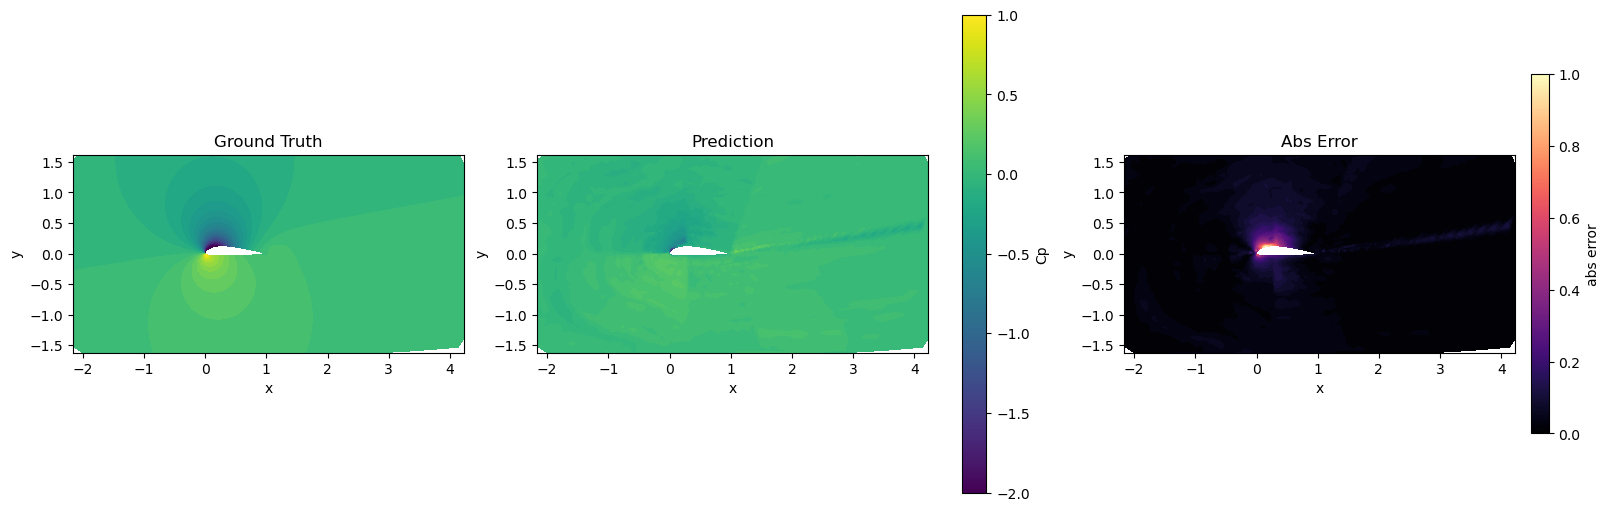

In [ ]:
# 15) Visualization: GT vs Prediction (tricontour with optional mask)
from matplotlib.tri import Triangulation
from matplotlib.path import Path
from utils import _poly_from_surface
import os
from datetime import datetime

@torch.no_grad()
def _predict_one_for_viz(d: Data):
    # Ensure pos3 + edges, normalize x/y, forward, return normalized dm and y_pred_norm
    dm = Data(**{k: v for k, v in d})
    if dm.x.size(1) == 5 or not getattr(dm, 'pos2_appended', False):
        dm = with_pos2(dm)
    assert hasattr(dm,'edge_index') and dm.edge_index is not None, 'edge_index missing'
    dm = ensure_edge_features(dm, want_dim=5)
    dm_norm = Data(**{k: v for k, v in dm})
    dm_norm.x = x_scaler.transform(dm.x)
    dm_norm.y = y_scaler.transform(dm.y)
    dm_run = dm_norm.to(device)
    
    # Temporarily disable AMP for visualization to avoid dtype issues
    model.eval()
    # Force float32 for visualization to avoid AMP dtype conflicts
    if hasattr(dm_run, 'x'):
        dm_run.x = dm_run.x.float()
    if hasattr(dm_run, 'edge_attr'):
        dm_run.edge_attr = dm_run.edge_attr.float()
        
    y_pred_norm = model(dm_run).detach().cpu()
    return dm_norm, y_pred_norm

@torch.no_grad()
def plot_pred_vs_gt(dm: Data, y_pred: torch.Tensor, channel: int = 2, show_mesh: bool = True, mask_airfoil: bool = True,
                    titles: tuple[str,str,str] = ('Ground Truth','Prediction','Abs Error'), cmap: str = 'viridis',
                    denormalize: bool = True, save_dir: str = "figures", save: bool = True):
    # Optionally denormalize both GT and prediction for visualization
    if denormalize and hasattr(dm, 'y'):
        dm_y_cpu = dm.y.detach().cpu()
        y_pred_cpu = y_pred.detach().cpu()
        gt = y_scaler.inverse(dm_y_cpu)
        pr = y_scaler.inverse(y_pred_cpu)
    else:
        gt = dm.y.detach().cpu()
        pr = y_pred.detach().cpu()

    # Prepare coordinates and values
    xy = (dm.pos if hasattr(dm,'pos') and dm.pos is not None else dm.x)[:, :2].detach().cpu().float().numpy()
    tri = Triangulation(xy[:,0], xy[:,1])

    # Denormalize x to physical for q and for robust airfoil polygon detection
    dm_x_cpu = dm.x.detach().cpu()
    x_phys = x_scaler.inverse(dm_x_cpu)  
    vx = float(x_phys[0, 0]); vy = float(x_phys[0, 1])
    v = math.sqrt(vx*vx + vy*vy)
    q = 0.5 * v * v

    gt_c = gt[:, channel].detach().cpu().float().numpy() / q
    pr_c = pr[:, channel].detach().cpu().float().numpy() / q
    err = np.abs(pr_c - gt_c)
    vmin = -2.0; vmax = 1.0

    # Optional mask of airfoil interior
    if mask_airfoil:
        try:
            x_np = x_phys.detach().cpu().numpy() if isinstance(x_phys, torch.Tensor) else np.asarray(x_phys)
            pos_np = (dm.pos if hasattr(dm,'pos') and dm.pos is not None else dm.x)[:, :2].detach().cpu().numpy()
            surf_mask = None
            try:
                wall = x_np[:, 2] if x_np.shape[1] >= 3 else None
                nxy = x_np[:, 3:5] if x_np.shape[1] >= 5 else None
                if nxy is not None:
                    surf_mask = (np.abs(nxy).sum(axis=1) > 1e-8)
                    if wall is not None:
                        surf_mask = np.logical_or(surf_mask, (wall < 1e-6))
                elif wall is not None:
                    surf_mask = (wall < 1e-6)
            except Exception:
                surf_mask = None

            poly = None
            if surf_mask is not None and np.any(surf_mask):
                pts = pos_np[surf_mask]
                if pts.shape[0] >= 3:
                    c = pts.mean(axis=0)
                    ang = np.arctan2(pts[:,1]-c[1], pts[:,0]-c[0])
                    order = np.argsort(ang)
                    poly = Path(pts[order], closed=True)

            if poly is not None:
                tris = tri.triangles
                centers = np.mean(np.stack([tri.x[tris], tri.y[tris]], axis=-1), axis=1)
                inside = poly.contains_points(centers, radius=-1e-6)
                if inside is not None and inside.any():
                    tri.set_mask(inside.astype(bool))
        except Exception:
            pass

    fig, ax = plt.subplots(1, 3, figsize=(16,5), constrained_layout=True)
    a1,a2,a3 = ax
    c1 = a1.tricontourf(tri, gt_c, levels=50, vmin=vmin, vmax=vmax, cmap=cmap)
    c2 = a2.tricontourf(tri, pr_c, levels=50, vmin=vmin, vmax=vmax, cmap=cmap)
    c3 = a3.tricontourf(tri, err, levels=50, cmap='magma')
    if show_mesh:
        for a in (a1,a2,a3):
            a.triplot(tri, color='k', lw=0.25, alpha=0.35)
    for a, t in zip((a1,a2,a3), titles):
        a.set_aspect('equal','box'); a.set_title(t); a.set_xlabel('x'); a.set_ylabel('y')
    m1 = plt.cm.ScalarMappable(cmap=cmap); m1.set_clim(vmin,vmax)
    fig.colorbar(m1, ax=[a1,a2], fraction=0.046, pad=0.04, label=f'Cp')
    fig.colorbar(plt.cm.ScalarMappable(cmap='magma'), ax=a3, fraction=0.046, pad=0.04, label='abs error')

    # === Save figure with timestamp ===
    if save:
        os.makedirs(save_dir, exist_ok=True)
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = os.path.join(save_dir, f"pred_vs_gt_channel{channel}_{timestamp}.png")
        plt.savefig(filename, dpi=200)
        print(f"[Saved] {filename}")

    plt.show()


# Example: visualize one sample (val if available, else train) — denormalized to capture actual flow physics
if isinstance(val_edges, list) or len(val_edges)==0:
    d_vis = train_edges[0] if len(train_edges)>0 else None
else:
    d_vis = val_edges[0] if len(val_edges)>0 else (train_edges[0] if len(train_edges)>0 else None)

if d_vis is not None:
    dm_vis_n, y_pred_vis_n = _predict_one_for_viz(d_vis)
    # Plot for pressure by default (channel 2). Change channel as needed (0=u, 1=v, 2=p_over_rho, 3=nu_t).
    plot_pred_vs_gt(dm_vis_n, y_pred_vis_n, channel=2, show_mesh=False, denormalize=True)
else:
    print('No sample available for visualization')
